In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import scipy.special as sp
from scipy.optimize import least_squares
from dgutils import colors as colortools
from scipy import interpolate
import os 
#from lmfit import minimize, Parameters, Parameter, report_fit,Model
%matplotlib inline

# plot style
#plt.style.reload_library()
#plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/IOP_Large.mplstyle'}


#figsize = plt.rcParams['figure.figsize'] 
#plt.rcParams ["figure.dpi"] = 72

dblsize = [0.86*6.4,0.86*2.86312]

%config InlineBackend.figure_format = 'svg'

In [2]:
filenames=os.listdir('../data/ed')
filenamesdmrg = os.listdir('../data/dmrg')

In [3]:
try:
    filenames.remove('.ipynb_checkpoints')
    filenamesdmrg.remove('.ipynb_checkpoints')
except:
    pass

In [4]:
def loaddata(α,v,ln):
    N=[]
    oneN=[]
    ent=[] 
    for i in range(len(filenames)):    
        fn = filenames[i]
        n = int(fn.split("_")[2][1:])
        Nval = int(fn.split("_")[4][1:])
        if Nval > 10 and n == ln:
            with open('../data/ed/'+fn,"r",encoding="utf-8",errors='ignore') as file:
                lines = file.readlines()
                nLines = len(lines)
            data = np.loadtxt('../data/ed/'+fn,encoding="utf-8")    
            try:
                V  = data[:,0]
                S1 = data[:,α]
            except IndexError:
                V = np.array([data[0]])
                S1 = np.array([data[α]])
            if v in V:
                N.append(Nval)
                oneN.append(1/Nval)
                idx = np.where(V==v)
                ent.append(np.exp(-S1[idx]))
    for i in range(len(filenamesdmrg)):    
        fn = filenamesdmrg[i]
        n = int(fn.split("_")[2][1:])
        Nval = int(fn.split("_")[4][1:])
        if Nval > 10 and n==ln:
            with open('../data/dmrg/'+fn,"r",encoding="utf-8",errors='ignore') as file:
                lines = file.readlines()
                nLines = len(lines)
            data = np.loadtxt('../data/dmrg/'+fn,encoding="utf-8")    
            try:
                V  = data[:,0]
                S1 = data[:,α]
            except IndexError:
                V = np.array([data[0]])
                S1 = np.array([data[α]])
            if v in V:
                N.append(Nval)
                oneN.append(1/Nval)
                idx = np.where(V==v)
                ent.append(np.exp(-S1[idx]))
    return N, oneN,ent

In [5]:
def g(v):
    k = np.pi/(2*np.arccos(-v/2))
    g=(k+1/k-2)/4
    return g

In [6]:
colors=["#0B2456","#1A896F","#bdd73c","#FF9F1C","#E71D36"]

C:\Users\harin\AppData\Local\Temp\ipykernel_30660\785431014.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  k = np.pi/(2*np.arccos(-v/2))


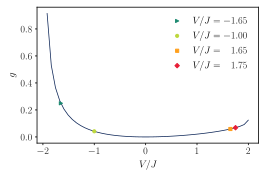

In [7]:
markers = {-1.65:'>',-1:'o',1.65:'s',1.75:'D'}
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    vs = np.linspace(-2,2)
    gvals = [g(v) for v in vs]
    for i,v in enumerate([-1.65,-1.000,1.65,1.75]):
        plt.scatter(v,g(v),color = colors[i+1],s=10,marker=markers[v], label=rf'$V/J={v:3.2f}$' if v<0 else r'$V/J=\phantom{-}'+f'{v:3.2f}$',zorder=10)
    plt.plot(vs,gvals,color="#0B2456")
    plt.legend(fontsize=10,handlelength=1.5)
    plt.xlabel(r'$V/J$')
    plt.ylabel(r'$g$')
    plt.savefig('../figures/Fig03_gvalues.pdf')

In [8]:
from scipy.optimize import curve_fit

In [9]:
from functools import partial
def scalingform(x,c1,c2,c3,c4,c5,v):
    exp = 4*g(v)
    return c1*x**4+c2*x**(3+exp)+c3*x**2+c4*x**(1+exp)+c5

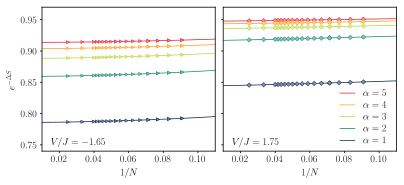

In [10]:
def fitfunc(x,a,b,c,d):
    return a*x**6+b*x**4+c*x**2+d
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig, axs = plt.subplots(1,2,sharey=True, constrained_layout=True, figsize=dblsize, sharex=False)
    #plt.subplots_adjust(wspace=.05) 
    ax1 = axs[0]
    v=-1.65
    for i,α in enumerate([5,4,3,2,1]):
        nval=1
        N, oneN, ent = loaddata(α,v,nval)
        oneN=np.array(oneN)
        ent = np.array(ent)
        ent=ent.reshape((-1,))
        fit, cov= curve_fit(fitfunc, oneN, ent)
        perr = np.sqrt(np.diag(cov))
        ratios=np.linspace(.01,.11,1000)
        #plt.plot(ratios,fitfunc(ratios,*fit),color=colors[i],label=f'α={α}:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{3.27}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)\frac{1}{N^{1.27}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
        ax1.plot(ratios,fitfunc(ratios,*fit),color=colors[α-1])
        #ax1.fill_between(ratios,fitfunc(ratios,*fit),fitfunc(ratios,*fit+perr),color=colors[α-1],alpha=.5)
        #ax1.fill_between(ratios,fitfunc(ratios,*fit),fitfunc(ratios,*fit-perr),color=colors[α-1],alpha=.5) 
        for j in range(len(ent)):
            ax1.scatter(oneN[j],ent[j],marker = '>',linewidths=0.5,s=10,
                        c=colortools.get_alpha_hex(colors[α-1],0.5),zorder=10, edgecolors=colors[α-1])
        #ax1.text(.121,fitfunc(.11,*fit),rf"$\alpha$={α}",ha="right",va="center",color=colors[i],size='xx-small')
    ax1.text(.015,.75,r'$V/J=-1.65$')
    ax1.set_xlabel(r'$1/N$')
    ax1.set_xlim(.01,.11)
    
    ax2 = axs[1]
    v=1.75
    for i,α in enumerate([5,4,3,2,1]):
            nval=1
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            scalingv=partial(scalingform,v=v)
            fit, cov= curve_fit(scalingv, oneN, ent)
            perr = np.sqrt(np.diag(cov))
            ratios=np.linspace(.01,.11,1000)
            #plt.plot(ratios,fitfunc(ratios,*fit),color=colors[i],label=f'α={α}:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{3.27}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)\frac{1}{N^{1.27}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
            ax2.plot(ratios, scalingv(ratios,*fit),color=colors[α-1],label=rf'$\alpha={α}$')
            #ax2.fill_between(ratios, scalingv(ratios,*fit), scalingv(ratios,*fit+perr),color=colors[i],alpha=.5)
            #ax2.fill_between(ratios, scalingv(ratios,*fit), scalingv(ratios,*fit-perr),color=colors[i],alpha=.5) 
            #for j in range(len(ent)):
            # old ax2.scatter(oneN,ent,marker = 'D',color=colors[i],s=6)
            ax2.scatter(oneN,ent,marker = 'D',linewidths=0.5,s=10,
                        c=colortools.get_alpha_hex(colors[α-1],0.5),zorder=10, edgecolors=colors[α-1])

    ax2.set_xlabel(r'$1/N$')
    ax2.legend(loc='lower right',bbox_to_anchor=(1,-.02),handlelength=1.5,handleheight=.2,labelspacing=.3,fontsize=10)
    #ax2.yaxis.set_tick_params(left=False)
    #plt.title(rf'n=1,v={v}, $2\gamma^2+1$=%.2f'%(1.27)) 
    ax2.set_xlim(.01,.11)
    ax2.text(.015,.75,r'$V/J=1.75$')
    #for ax in fig.get_axes():
     #   ax.label_outer()
    #fig.add_subplot(111, frameon=False)
    #plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    #plt.grid(False)
    ax1.set_ylabel(r'$e^{-\Delta S}$')
    ax1.set_ylim(.74,.97)
    plt.savefig('../Figures/Fig06_n1diffalphas.pdf')


In [11]:
def fitfunc1(x,b,c,d):
    return b*x**4+c*x**2+d
from functools import partial
def scalingform(x,c1,c2,c3,c4,c5,v):
    exp = 4*g(v)
    return c1*x**4+c2*x**(3+exp)+c3*x**2+c4*x**(1+exp)+c5

$v=-1.65$:$(-1.01091e+01\pm6.590e-01)\frac{1}{N^{4}}+(8.55475e-01\pm6.084e-03)\frac{1}{N^{2}}+(7.859199e-01\pm1.156e-05)$


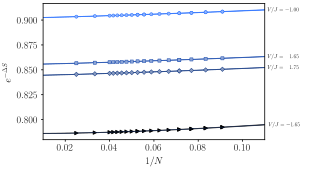

In [12]:
markers = {-1.65:'>',-1:'o',1.65:'s',1.75:'D'}
#coloralpha={-1.65:'#000000',1.75:'#0B2456',1.65:'#113782',-1:'#1749AD'}
coloralpha1={-1.65:'#000000',1.75:'#113782',1.65:'#1749AD',-1:'#216BFF'}
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig,ax=plt.subplots()
    for i,v in enumerate([-1.65,-1.0,1.65,1.75]):
            nval=1
            α=1
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            if v == -1.65:
                fit, cov= curve_fit(fitfunc1, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                ratios=np.linspace(.01,.11,1000)
                print(rf'$v={v}$:'+(r'$(%.5e\pm%.3e)\frac{1}{N^{4}}+(%.5e\pm%.3e)\frac{1}{N^{2}}+(%.6e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2])))
                plt.plot(ratios,fitfunc1(ratios,*fit),linewidth=.5,color=colors[i],label=f'α={α}')
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit+perr),color=coloralpha1[v],alpha=.5)
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit-perr),color=coloralpha1[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],color=coloralpha1[v],s=10)
                plt.text(.122,fitfunc1(.11,*fit),rf'$V/J={v:3.2f}$' if v<0 else r'$V/J=\phantom{-}'+f'{v:3.2f}$',ha="center",va="center",size='xx-small')
            else: 
                scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                #ratios=np.linspace(.01,.11,1000)
                #print(rf'$v={v}$:'+(r'$(%.5e\pm%.3e)\frac{1}{N^{4}}+(%.5e\pm%.3e)\frac{1}{N^{3.27}}+(%.6e\pm%.3e)\frac{1}{N^{2}}+(%.6e\pm%.3e)\frac{1}{N^{1.27}}+(%.8e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                plt.plot(ratios,scalingv(ratios,*fit),linewidth=.5,color=coloralpha1[v],label=f'α={α}')
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit+perr),color=coloralpha1[v],alpha=.5)
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit-perr),color=coloralpha1[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],linewidths=0.5,s=10,c=colortools.get_alpha_hex(coloralpha1[v],0.5),zorder=10, edgecolors=coloralpha1[v])
                plt.text(.1215,scalingv(.11,*fit),rf'$V/J={v:3.2f}$' if v<0 else r'$V/J=\phantom{-}'+f'{v:3.2f}$',ha="center",va="center",size='xx-small')
    ax.set_xlabel(r'$1/N$')
    ax.set_ylabel(r'$e^{-\Delta S}$')
    #plt.legend(loc="upper center",bbox_to_anchor=(3.2,.8))
    plt.xlim(.01,.11)
    plt.savefig('../figures/Fig05_alpha1diffV.pdf')
    plt.show()


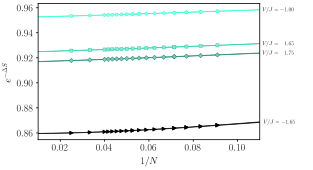

In [13]:
markers = {-1.65:'>',-1:'o',1.65:'s',1.75:'D'}
#coloralpha2={-1.65:'#000000',1.75:"#115948",1.65:'#1A896F',-1:'#27CFA8'}
coloralpha2={-1.65:'#000000',1.75:'#1A896F',1.65:'#27CFA8',-1:'#30FFCF'}
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig,ax=plt.subplots()
    for i,v in enumerate([-1.65,-1.0,1.65,1.75]):
            nval=1
            α=2
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            if v == -1.65:
                fit, cov= curve_fit(fitfunc1, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                ratios=np.linspace(.01,.11,1000)
                plt.plot(ratios,fitfunc1(ratios,*fit),linewidth=.5,color=coloralpha2[v],label=rf'$\alpha={α}$:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2])))
                #plt.plot(ratios,fitfunc(ratios,*fit),color=colors[i],label=f'α={α}')
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit+perr),color=coloralpha2[v],alpha=.5)
                plt.fill_between(ratios,fitfunc1(ratios,*fit),fitfunc1(ratios,*fit-perr),color=coloralpha2[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],color=coloralpha2[v],s=10)
                plt.text(.122,fitfunc1(.11,*fit),rf'$V/J={v:3.2f}$' if v<0 else r'$V/J=\phantom{-}'+f'{v:3.2f}$',ha="center",va="center",size='xx-small')
            else: 
                scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                #ratios=np.linspace(.01,.11,1000)
                #plt.plot(ratios,scalingv(ratios,*fit),color=colors[i],label=rf'$\alpha={α}$:'+(r'$(%.3e\pm%.3e)\frac{1}{N^{4}}+(%.3e\pm%.3e)\frac{1}{N^{3.27}}+(%.3e\pm%.3e)\frac{1}{N^{2}}+(%.3e\pm%.3e)\frac{1}{N^{1.27}}+(%.3e\pm%.3e)$'%(fit[0],perr[0],fit[1],perr[1],fit[2],perr[2],fit[3],perr[3],fit[4],perr[4])))
                plt.plot(ratios,scalingv(ratios,*fit),linewidth=.5,color=coloralpha2[v],label=f'α={α}')
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit+perr),color=coloralpha2[v],alpha=.5)
                plt.fill_between(ratios,scalingv(ratios,*fit),scalingv(ratios,*fit-perr),color=coloralpha2[v],alpha=.5) 
                for j in range(len(ent)):
                    plt.scatter(oneN[j],ent[j],marker = markers[v],linewidths=0.5,s=10,c=colortools.get_alpha_hex(coloralpha2[v],0.5),zorder=10, edgecolors=coloralpha2[v])
                plt.text(.1215,scalingv(.11,*fit),rf'$V/J={v:3.2f}$' if v<0 else r'$V/J=\phantom{-}'+f'{v:3.2f}$',ha="center",va="center",size='xx-small')
    ax.set_xlabel(r'$1/N$')
    ax.set_ylabel(r'$e^{-\Delta S}$')
    #plt.legend()
       #plt.title(rf'n=1,v={v}, $2\gamma^2+1$=%.2f'%(1.27)) 
    plt.xlim(.01,.11)
    plt.savefig('../figures/Fig04_alpha2diffV.pdf')
    plt.show()


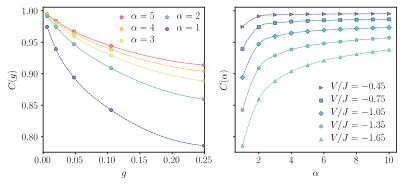

In [14]:
vs = [-.45,-.75,-1.05,-1.35,-1.65]
colors=["#0B2456","#1A896F","#bdd73c","#FF9F1C","#E71D36"]
def fitfunc(x,a,b,c,d):
    return a*x**6+b*x**4+c*x**2+d
plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig, axs = plt.subplots(1,2,sharey=True, constrained_layout=True, figsize=dblsize, sharex=False)
    #plt.subplots_adjust(wspace=.05) 
    ax1 = axs[0]
    for i, α in enumerate([5,4,3,2,1]):
        cg=[]
        gvals = []
        cerror=[]
        for v in vs:
            nval=1
            N, oneN, ent = loaddata(α,v,nval)
            oneN=np.array(oneN)
            ent = np.array(ent)
            ent=ent.reshape((-1,))
            if v == -1.65:
                fit, cov= curve_fit(fitfunc1, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                cg.append(fit[2])
                cerror.append(perr[2]) 
            else:
                scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                cg.append(fit[4])
                cerror.append(perr[4]) 
            gvals.append(g(v))
        f=interpolate.interp1d(gvals,cg,kind='quadratic')
        gvals=np.array(gvals)
        ginterp=np.linspace(min(gvals),max(gvals),1000)
        ax1.plot(ginterp,f(ginterp),linestyle='--',linewidth=.5,color=colors[α-1])
        ax1.scatter(gvals,cg,marker='o',linewidths=0.5,s=10,c=colortools.get_alpha_hex(colors[α-1],0.5),zorder=10, edgecolors=colors[α-1],label=rf'$\alpha={α}$')
    ax1.set_xlabel(r'$g$')
    ax1.set_ylabel(r'$C(g)$')
    ax1.set_xlim(0,.25)
    ax2 = axs[1]
    colors=['#442a58','#035089','#0075a0','#24957F','#3CB371']
    markers=['>','s','D','o','^']
    alphas=[1,2,3,4,5,6,7,8,9,10]
    alphainterp=np.linspace(1,10,1000)
    for i,v in enumerate([-.45,-.75,-1.05,-1.35,-1.65]):
            cα=[]
            cerror=[]
            for α in alphas:
                nval=1
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                if v == -1.65:
                    fit, cov= curve_fit(fitfunc1, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    cα.append(fit[2])
                    cerror.append(perr[2]) 
                else:
                    scalingv=partial(scalingform,v=v)
                    fit, cov= curve_fit(scalingv, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    cα.append(fit[4])
                    cerror.append(perr[4])
            f=interpolate.interp1d(alphas,cα,kind='quadratic')
            ax2.plot(alphainterp,f(alphainterp),linestyle='--',linewidth=.5,color=colors[i])
            ax2.scatter(alphas,cα,marker=markers[i],linewidths=0.5,s=10,c=colortools.get_alpha_hex(colors[i],0.5),zorder=10, edgecolors=colors[i],label=rf'$V/J={v:3.2f}$' if v<0 else r'$V/J=\phantom{-}'+f'{v:3.2f}$')
           # if v == -1.65:
           #     plt.text(11.8,fit[2],rf"$V/J={v}$",ha="right",va="center",size='xx-small')
            #else:
             #   plt.text(11.8,fit[4],rf"$V/J={v}$",ha="right",va="center",size='xx-small')
    ax2.legend(fontsize=10,handletextpad=.2,handlelength=1.5,handleheight=.2,labelspacing=.3)
    ax2.set_xlabel(r'$\alpha$')
    ax2.set_ylabel(r'$C(\alpha)$')
    ax1.legend(loc='upper right',fontsize=10,bbox_to_anchor=(1.035,1.03),handletextpad=.2,handlelength=1.5,handleheight=.2,columnspacing=.4,labelspacing=.3,ncol=2)

    plt.savefig('../Figures/Fig07_constants.pdf')


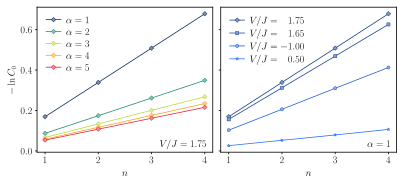

In [15]:
#colorsblue=['#000000','#113782','#1749AD','#216BFF']
colorsblue=['#113782','#144099','#1C5AD6','#216BFF']
markers=['x','o','s','D']
markers=['D','s','o','*']
def fitfunc23(x,a,b,c,d,e):
    return a*x**4+b*x**3+c*x**2+d*x+e

plt.style.reload_library()
with plt.style.context('../include/IOP.mplstyle'):
    fig, axs = plt.subplots(1,2,sharey=True, sharex=False, figsize=dblsize, constrained_layout=True)
    #plt.subplots_adjust(wspace=.05) 
    ax1 = axs[1]
    α=1
    for i,v in enumerate([1.75,1.65,-1.0,.5]):
        constants=[]
        for nval in [1,2,3,4]:
            if nval == 1:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                if v == -1.65:
                    scalingv=fitfunc1
                else:
                    scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
                ratios=np.linspace(0,.1,1000)
            else:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                fit, cov= curve_fit(fitfunc23, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
        ax1.plot([1,2,3,4],constants,color=colorsblue[i],marker=markers[i],ms=np.sqrt(10),label=f"$V/J={v:3.2f}$" if v<0 else r'$V/J=\phantom{-}$'+rf'${v:3.2f}$',
                mfc=colortools.get_alpha_hex(colorsblue[i],0.5),zorder=10, mec=colorsblue[i],mew=0.5)
    ax1.set_xlabel(r'$n$')
    ax1.legend(fontsize=10,handletextpad=.5, handlelength=1.5,labelspacing=.3)
    ax2=axs[0]
    v=1.75
    colors=["#0B2456","#1A896F","#bdd73c","#FF9F1C","#E71D36"]
    for i,α in enumerate([1,2,3,4,5]):
        constants=[]
        for nval in [1,2,3,4]:
            if nval == 1:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                if v == -1.65:
                    scalingv=fitfunc1
                else:
                    scalingv=partial(scalingform,v=v)
                fit, cov= curve_fit(scalingv, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
                ratios=np.linspace(0,.1,1000)
            else:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                fit, cov= curve_fit(fitfunc23, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                constants.append(-np.log(fit[-1]))
        ax2.plot([1,2,3,4],constants,color=colors[i],marker='D',ms=np.sqrt(10),label=rf'$\alpha={α}$',
                mfc=colortools.get_alpha_hex(colors[i],0.5),zorder=10, mec=colors[i],mew=0.5)
    ax2.legend(loc='upper left',handletextpad=.5, handlelength=1.5,labelspacing=.3,fontsize=10)
    ax2.set_xlabel(r'$n$')
    ax2.set_ylabel(r'$-\ln{C_0}$')
    ax2.text(3.15,.02,r'$V/J=1.75$')
    ax1.text(3.6,.02,r'$\alpha=1$')
    plt.savefig('../figures/Fig09_linearn.pdf')

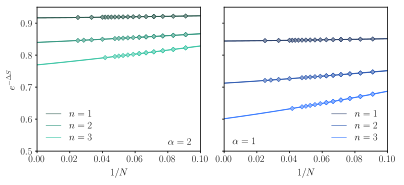

In [16]:
with plt.style.context('../include/IOP.mplstyle'):
    fig, axs = plt.subplots(1,2,sharey=True, constrained_layout=True, figsize=dblsize, sharex=False)
    #plt.subplots_adjust(wspace=.05) 
    ax1 = axs[0]
    colorsgreen=['#0C4034','#1A8A70','#24BF9B']
    def fitfunc23(x,a,b,c,d,e):
        return a*x**4+b*x**3+c*x**2+d*x+e
    for v in [1.75]:
        for α in [2]:
            for i, nval in enumerate([1,2,3]):
                if nval == 1:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fitfunc175=scalingv=partial(scalingform,v=v)
                    fit, cov= curve_fit(fitfunc175, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    ax1.plot(ratios,fitfunc175(ratios,*fit),color=colorsgreen[i],linewidth=.5,label=rf'$n={nval}$')
                    ax1.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit+perr),color=colorsgreen[i],alpha=.5)
                    ax1.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit-perr),color=colorsgreen[i],alpha=.5)  
                    for j in range(len(ent)):
                        ax1.scatter(oneN[j],ent[j],marker='D',linewidths=0.5,s=10,c=colortools.get_alpha_hex(colorsgreen[i],0.5),zorder=10, edgecolors=colorsgreen[i])
                else:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fit, cov= curve_fit(fitfunc23, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    ax1.plot(ratios,fitfunc23(ratios,*fit),linewidth=.5,color=colorsgreen[i],label=rf'$n={nval}$')
                    ax1.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit+perr),color=colorsgreen[i],alpha=.5)
                    ax1.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit-perr),color=colorsgreen[i],alpha=.5)  
                    for j in range(len(ent)):
                        ax1.scatter(oneN[j],ent[j],marker='D',linewidths=0.5,s=10,c=colortools.get_alpha_hex(colorsgreen[i],0.5),zorder=10, edgecolors=colorsgreen[i])
    ax1.set_xlabel(r'$1/N$')
    ax1.set_ylabel(r'$e^{-\Delta S}$')
    ax1.set_xlim(0,.1)
    ax1.legend(handlelength=1.5,handleheight=.2,labelspacing=.3,fontsize=10)
    ax2 = axs[1]
    colorsblue=['#0B2457','#1647A8','#216BFF']
    for v in [1.75]:
        for α in [1]:
            for i, nval in enumerate([1,2,3]):
                if nval == 1:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fitfunc175=scalingv=partial(scalingform,v=v)
                    fit, cov= curve_fit(fitfunc175, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    ax2.plot(ratios,fitfunc175(ratios,*fit),color=colorsblue[i],linewidth=.5,label=rf'$n={nval}$')
                    ax2.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit+perr),color=colorsblue[i],alpha=.5)
                    ax2.fill_between(ratios,fitfunc175(ratios,*fit),fitfunc175(ratios,*fit-perr),color=colorsblue[i],alpha=.5)  
                    for j in range(len(ent)):
                        ax2.scatter(oneN[j],ent[j],marker='D',linewidths=0.5,s=10,c=colortools.get_alpha_hex(colorsblue[i],0.5),zorder=10, edgecolors=colorsblue[i])
                else:
                    N, oneN, ent = loaddata(α,v,nval)
                    oneN=np.array(oneN)
                    ent = np.array(ent)
                    ent=ent.reshape((-1,))
                    fit, cov= curve_fit(fitfunc23, oneN, ent)
                    perr = np.sqrt(np.diag(cov))
                    ratios=np.linspace(0,.1,1000)
                    ax2.plot(ratios,fitfunc23(ratios,*fit),color=colorsblue[i],linewidth=.5,label=rf'$n={nval}$')
                    ax2.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit+perr),color=colorsblue[i],alpha=.5)
                    ax2.fill_between(ratios,fitfunc23(ratios,*fit),fitfunc23(ratios,*fit-perr),color=colorsblue[i],alpha=.5)  
                    for j in range(len(ent)):
                        ax2.scatter(oneN[j],ent[j],marker='D',linewidths=0.5,s=10,c=colortools.get_alpha_hex(colorsblue[i],0.5),zorder=10, edgecolors=colorsblue[i])
    ax2.set_xlabel(r'$1/N$')
    ax2.set_xlim(0,.1)
    ax1.set_ylim(.5,.95)
    ax2.legend(handlelength=1.5,handleheight=.2,labelspacing=.3,fontsize=10)
    ax2.text(.005,.522,r'$\alpha=1$',size=10)
    ax1.text(.08,.52,r'$\alpha=2$',size=10)
    fig.savefig('../Figures/Fig08_diffn.pdf')

In [17]:
for v in [1.75]:
    for α in [1]:
        for i, nval in enumerate([1,2,3]):
            if nval == 1:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                fitfunc175=partial(scalingform,v=v)
                fit, cov= curve_fit(fitfunc175, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                print(nval,fit)
                print(perr[-1])
                print(-np.log(fit[-1]))
                print(perr[-1]/fit[-1])
                print(-np.log(fit[-1])/(np.pi*nval))
                print((perr[-1]/fit[-1])/(np.pi*nval))
            else:
                N, oneN, ent = loaddata(α,v,nval)
                oneN=np.array(oneN)
                ent = np.array(ent)
                ent=ent.reshape((-1,))
                
                fit, cov= curve_fit(fitfunc23, oneN, ent)
                perr = np.sqrt(np.diag(cov))
                print(nval,fit)
                print(perr[-1])
                print(-np.log(fit[-1]))
                print(perr[-1]/fit[-1])
                print(-np.log(fit[-1])/(np.pi*nval))
                print((perr[-1]/fit[-1])/(np.pi*nval))

1 [ 1.27960734 -0.55088942  0.03098267  0.13171148  0.84420619]
2.0172737595767978e-07
0.16935850892585302
2.3895510062577474e-07
0.05390848770044478
7.606177088322661e-08
2 [16.14152143 -5.81877421  1.25401595  0.30708695  0.71247674]
5.803778142407444e-06
0.3390080108654217
8.145919444470073e-06
0.05395480067698283
1.2964633456157982e-06
3 [16.22985583 -5.79290062  2.05863213  0.69486842  0.60125355]
5.917392302171235e-06
0.5087385569047865
9.841758645770802e-06
0.05397883738188951
1.0442430247945473e-06


In [18]:
0.70747/(3*np.pi)

0.07506489839281547